# Sentiment Analysis with MLP Classifier
We will develop MLP sentiment classifiers for a movie review dataset and then we will predict the number of positive and negative reviews based on a test set. For each classifier we set and tune some of the parameters such as layers, dropouts, activation functions, loss functions etc. Then, we will calculate the precision, recall, F1, precision-recall AUC scores and their learning curves. 
### 3rd Assignment


---
 >Panagiotis Giannopoulos, P3352102 <br />
 >MSc in Data Science <br />
 >Athens University of Economics and Business <br />
 pgiannopoulos@aueb.gr

**Install required packages**

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install kaggle
!pip install --upgrade tensorflow

**Check assigned GPU**

In [ ]:
!nvidia-smi

Wed May 25 16:36:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset
For the scope of our analysis we use the IMDB Dataset of 50K Movie Reviews from Kaggle. <br>
* https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

IMDB dataset has 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. The dataset provides a set of 25,000 positive movie reviews and 25,000 negative movie reviews. So, we can predict the number of positive and negative reviews using either classification or deep learning algorithms. 

#### **Download and import the dataset**

In [ ]:
#Mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Configure Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

#Move to Kaggle directory
%cd /content/drive/My Drive/Kaggle/

#Download Dataset
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

**Import the dataset**

In [ ]:
import pandas as pd
import numpy as np

#Importing the dataset

imdb_data=pd.read_csv('/content/drive/My Drive/Kaggle/IMDB Dataset.csv', encoding='utf-8')
print("Dimensions of the dataset: ", imdb_data.shape, '\n')
imdb_data.head(10)

Dimensions of the dataset:  (50000, 2) 



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


####  **Preprocess dataset**
We begin the cleaning by dropping the duplicate values, then we clean the text from HTML marks and others pecularities. Then we tokenize the dataset and lemmatize it. After the above jobs we join the tokens again and reconstruct the dataset. 

At the end we use the Label Binezer one hot encoding the sentiment values. 
* Positive:  1
* Negative: 0 

**Drop duplicate values**

In [ ]:
#Drop duplicate values
imdb_data = imdb_data.drop_duplicates(subset = ['review'])

#Sentiment count
imdb_data['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

**Cleaning the dataset**

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from nltk.stem import WordNetLemmatizer

# Copy and create the new dataset
imdb_data_new = imdb_data[['review','sentiment']].copy()

#Remove html noise (like <br />)
imdb_data_new['review'] = [re.sub(r'<.*?>', ' ', str(x)) for x in imdb_data_new['review']]

#Remove non-word (special) characters such as punctuation, numbers etc
imdb_data_new['review'] = [re.sub(r'\W', ' ', str(x)) for x in imdb_data_new['review']]

#Remove all single characters
imdb_data_new['review'] = [re.sub(r'\s+[a-zA-Z]\s+', ' ', str(x)) for x in imdb_data_new['review']]

#Substitute multiple spaces with single space
imdb_data_new['review'] = [re.sub(r'\s+', ' ', str(x), flags=re.I) for x in imdb_data_new['review']]

#Convert to lowercase
imdb_data_new['review'] = imdb_data_new['review'].str.lower()

**Tokenize the sentences and lemmatize the words**

In [ ]:
# Split the document based on whitespaces (--> List of words) & Lemmatization

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

imdb_data_new['review'] = imdb_data_new.review.apply(lemmatize_text)

# Reconstruct the document by joining the words on each whitespace
imdb_data_new['review'] = [' '.join(x) for x in imdb_data_new['review']]

**One hot enconding sentiment values**

In [ ]:
from sklearn.preprocessing import LabelBinarizer

#Labeling the sentiment data
lb=LabelBinarizer()
#Transformed sentiment data (positive:1, negative:0)
imdb_data_new['sentiment'] = lb.fit_transform(imdb_data_new['sentiment'])
imdb_data_new

,review,sentiment
0,one of the other reviewer ha mentioned that af...,1
1,a wonderful little production the filming tech...,1
2,i thought this wa wonderful way to spend time ...,1
3,basically there a family where little boy jake...,0
4,petter mattei love in the time of money is vis...,1
...,...,...
49995,i thought this movie did down right good job i...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am catholic taught in parochial elementary s...,0
49998,i going to have to disagree with the previous ...,0


### **Split dataset**
We split the dataset in 
* Train (70%)
* Development (15%) 
* Test (15%)

We separate the data as training set and development set to increase reliability. We will train our models with the training dataset and evaluate with the development data and after determining the most suitable hyperparameters for the model, apply it to the test dataset.

In [ ]:
from sklearn.model_selection import train_test_split  

x_traindev, x_test, y_traindev, y_test = train_test_split(imdb_data_new.review, imdb_data_new.sentiment, test_size=0.15, random_state=155)
x_train, x_dev, y_train, y_dev = train_test_split(x_traindev, y_traindev, test_size=0.1765, random_state=155)

In [ ]:
print('Training set    : ', len(x_train))
print('Development set : ', len(x_dev))
print('Test set        : ', len(x_test))

Training set    :  34705
Development set :  7439
Test set        :  7438


### **Feature extraction (Tf-IDF n-gram features)**



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Exclude stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    sublinear_tf = True, 
    max_features = 1000,
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - development - test)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_dev_tfidf = vectorizer.transform(x_dev)
x_test_tfidf = vectorizer.transform(x_test)

print('\nShape of training data:    {}'.format(x_train_tfidf.shape))
print('Shape of development data: {}'.format(x_dev_tfidf.shape))
print('Shape of test data:        {}\n'.format(x_test_tfidf.shape))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

Shape of training data:    (34705, 1000)
Shape of development data: (7439, 1000)
Shape of test data:        (7438, 1000)



### **Dimensionality reduction (SVD)**

We will perform dimension reduction in our features. We will use the SVD method and we will keep ***100*** components.

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=100, random_state=4321) 

x_train_svd = svd.fit_transform(x_train_tfidf)
x_dev_svd = svd.transform(x_dev_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

print('Shape of training data:    {} --> {}'.format(x_train_tfidf.shape, x_train_svd.shape))
print('Shape of development data: {} --> {}'.format(x_dev_tfidf.shape, x_dev_svd.shape))
print('Shape of testing data:     {} --> {}'.format(x_test_tfidf.shape, x_test_svd.shape))

Shape of training data:    (34705, 1000) --> (34705, 100)
Shape of development data: (7439, 1000) --> (7439, 100)
Shape of testing data:     (7438, 1000) --> (7438, 100)


## **Classifiers**

In our sentiment analysis we will create ***4 MLP classifiers*** and compare them with the best results from our previous assignment.



**Function for evalution the models**

Before we begin we will create a function to evaluate our models.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def evaluation(model, X, y):
  predictions_test = np.argmax(model.predict(X), -1)
  report_test = classification_report(y, predictions_test, target_names=['Negative','Positive'], digits = 4)
  print(report_test)
  print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y, model.predict(X)[:, 0])))
  print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y, model.predict(X)[:, 1])),'\n')
  print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y, np.argmax(model.predict(X), -1))),'\n')

#### **Baseline Classifiers**



##### **Dummy Classifier (first baseline)**

At first we will produce a Dummy Classifier as our first baseline to test our results.

Training took: 0.0016787052154541016 seconds 

Train accuracy: 50.20%
Development accuracy: 49.09% 
Test accuracy: 48.71% 

#Class 0 in Train dataset: (17423,)
#Class 1 in Train dataset: (17282,) 



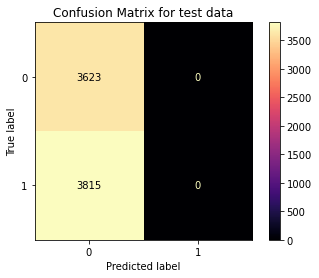

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = baseline.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_dev = baseline.predict(x_dev_tfidf)
score = accuracy_score(y_dev, predictions_dev)
print("Development accuracy: {:.2f}% ".format(score*100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape,'\n')

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(baseline, x_test_tfidf, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

##### **Logistic Regression (second baseline)**

Logistic Regression classifier gave the best results in our second assignment. So, we will use mostly it, to compare with the MLPs. 



**Create and Tuning Classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

model = LogisticRegression()

grid_params = {
  'solver': ['liblinear'],
  'C': np.linspace(0.1, 1, 10),
  'max_iter': [50, 100, 200],
}

# Train
# Solver -- Algorithm to use in the optimization problem.
clf = RandomizedSearchCV(model, grid_params, scoring='f1', n_jobs=-1, n_iter=100)
start_time = time.time()
clf.fit(x_train_svd, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate in development data
val_score=clf.score(x_dev_svd, y_dev)

print("Validation Score: {:.4f}".format(val_score))
print("Best Score: {:.4f}".format(clf.best_score_),'\n')
print("Best Parameters: ", clf.best_params_)

Training took: 42.470308780670166 seconds 

Validation Score: 0.8513
Best Score: 0.8467 

Best Parameters:  {'solver': 'liblinear', 'max_iter': 50, 'C': 1.0}


**Evaluate Classifier**

In [ ]:
# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')

### Create classifier that fits in train and development data ###
clf_lr_svd_est = LogisticRegression(**clf.best_params_)
clf_lr_svd = LogisticRegression(**clf.best_params_).fit(x_train_svd, y_train)


##### Evaluate #####

# Training Data
predictions = clf_lr_svd.predict(x_train_svd)
report_training = classification_report(y_train, predictions, target_names=['Negative','Positive'], digits = 4)
print("--------------------Training Data--------------------")
print(report_training)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_train, clf_lr_svd.predict_proba(x_train_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_train, clf_lr_svd.predict_proba(x_train_svd)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_train, clf_lr_svd.predict(x_train_svd))),'\n')

# Developmnent Data
predictions_dev = clf_lr_svd.predict(x_dev_svd)
report_dev = classification_report(y_dev, predictions_dev, target_names=['Negative','Positive'], digits = 4)
print("-------------------Development Data-------------------")
print(report_dev)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_dev, clf_lr_svd.predict_proba(x_dev_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_dev, clf_lr_svd.predict_proba(x_dev_svd)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_dev, clf_lr_svd.predict(x_dev_svd))),'\n')

--------------------Training Data--------------------
              precision    recall  f1-score   support

    Negative     0.8545    0.8368    0.8455     17423
    Positive     0.8388    0.8563    0.8475     17282

    accuracy                         0.8465     34705
   macro avg     0.8466    0.8465    0.8465     34705
weighted avg     0.8467    0.8465    0.8465     34705

PR-AUC score Negative: 0.0747
PR-AUC score Positive: 0.9253 

Macro average PR-AUC score: 0.7898 

-------------------Development Data-------------------
              precision    recall  f1-score   support

    Negative     0.8488    0.8395    0.8442      3652
    Positive     0.8469    0.8558    0.8513      3787

    accuracy                         0.8478      7439
   macro avg     0.8479    0.8477    0.8477      7439
weighted avg     0.8478    0.8478    0.8478      7439

PR-AUC score Negative: 0.0729
PR-AUC score Positive: 0.9271 

Macro average PR-AUC score: 0.7982 



**Testing Classifier**

----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative     0.8493    0.8383    0.8437      3623
    Positive     0.8483    0.8587    0.8535      3815

    accuracy                         0.8487      7438
   macro avg     0.8488    0.8485    0.8486      7438
weighted avg     0.8488    0.8487    0.8487      7438

PR-AUC score Negative: 0.0724
PR-AUC score Positive: 0.9276 

Macro average PR-AUC score: 0.8009 



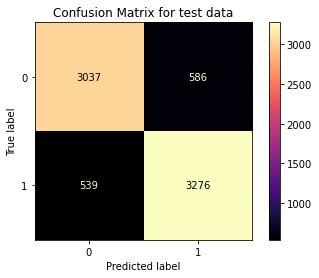

In [ ]:
# Testing data
predictions_test = clf_lr_svd.predict(x_test_svd)
report_test = classification_report(y_test, predictions_test, target_names=['Negative','Positive'], digits = 4)
print("----------------------Test Data----------------------")
print(report_test)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_test, clf_lr_svd.predict_proba(x_test_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_test, clf_lr_svd.predict_proba(x_test_svd)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_test, clf_lr_svd.predict(x_test_svd))),'\n')

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf_lr_svd, x_test_svd, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

### **MLP classifiers**

We create and use four MLPs for our sentiment analysis. In each MLP we try different parameters and at the end we will keep the best of them. At first we will define some functions to evaluate and handle better our results.

**Custom Keras callback for calculating f1, precision, recall at the end of each epoch** 

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np
import os


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)      
        

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

**Convert labels to 1-hot vectors**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_1_hot(y_set):
  # integer encode
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(y_set)

  # binary encode
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  return(onehot_encoded)

In [ ]:
y_train_1_hot = encode_1_hot(y_train)
y_dev_1_hot = encode_1_hot(y_dev)
y_test_1_hot = encode_1_hot(y_test)

#### **MLP classifier 1**

* **Layers:** three 
* **Activation function:** relu and softmax(final)
* **Dropout:** 0.5
* **Loss function:** categorical cross entropy
* **Optimizer:** Adam (0.01 learning rate)


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# simple early stopping
es = EarlyStopping(monitor='val_f1', mode='min', verbose=1, patience = 10)

with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(512, input_dim=x_train_svd.shape[1] , activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256,  activation='relu'))
  model.add(Dense(len(y_train_1_hot[0]),  activation='softmax'))

  print(model.summary())
  model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.01),
                    metrics=["accuracy"])

  if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

  checkpoint = ModelCheckpoint('checkpoints/weights.hdf5',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)

  history = model.fit(x_train_svd, y_train_1_hot,
                validation_data=(x_dev_svd, y_dev_1_hot),
                batch_size=256,
                epochs=100,
                shuffle=True,
                callbacks=[Metrics(valid_data=(x_dev_svd, y_dev_1_hot)),
                checkpoint,es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 183,554
Trainable params: 183,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
233/233 [==============================] - 0s 2ms/step
 — val_f1: 0.843329 — val_precision: 0.843553 — val_recall: 0.843393

Epoch 1: val_f1 improved from -inf to 0.

**Visualize Model's Training History**


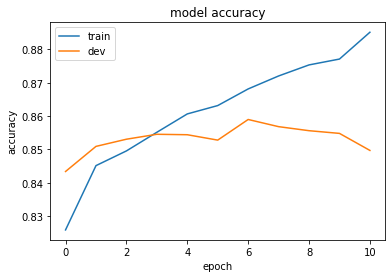

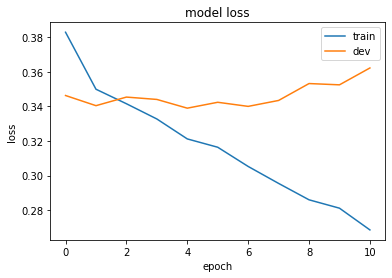

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_hist():
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'dev'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'dev'], loc='upper right')
  plt.show()

plot_hist()

**Evaluate performance of tf-idf MLP model**

In [ ]:
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Change model layers etc as before

with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(512, input_dim=x_dev_svd.shape[1] , activation='relu'))
  model.add(Dense(256,  activation='relu'))
  model.add(Dense(len(y_train.unique()),  activation='softmax'))
  #load weights from the pre-trained model
  model.load_weights("checkpoints/weights.hdf5")
  model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.01),
                    metrics=["accuracy"])

  print("\n----------------------Train Data----------------------")
  evaluation(model, x_train_svd, y_train)
  print("\n------------------Development Data-------------------")
  evaluation(model, x_dev_svd, y_dev)
  print("\n----------------------Test Data----------------------")
  evaluation(model, x_test_svd, y_test)
  


----------------------Train Data----------------------
1085/1085 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

    Negative     0.8903    0.8883    0.8893     17423
    Positive     0.8876    0.8897    0.8887     17282

    accuracy                         0.8890     34705
   macro avg     0.8890    0.8890    0.8890     34705
weighted avg     0.8890    0.8890    0.8890     34705

1085/1085 [==============================] - 2s 1ms/step
PR-AUC score Negative: 0.0401
1085/1085 [==============================] - 2s 1ms/step
PR-AUC score Positive: 0.9599 

1085/1085 [==============================] - 2s 1ms/step
Macro average PR-AUC score: 0.8446 


------------------Development Data-------------------
233/233 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

    Negative     0.8571    0.8554    0.8562      3652
    Positive     0.8608    0.8624    0.8616      3787

    accuracy    

#### **MLP classifier 2**

* **Layers:** three 
* **Activation function:** relu and softmax(final)
* **Dropout:** 0.7
* **Loss function:** binary cross entropy
* **Optimizer:** Adam (0.01 learning rate)

Changes from the previous
1.   Dropout from 0.5 to 0.7 
2.   Loss function from categorical to binary cross entropy

In [ ]:
with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(512, input_dim=x_train_svd.shape[1] , activation='relu'))
  model.add(Dropout(0.7))
  model.add(Dense(256,  activation='relu'))
  model.add(Dense(len(y_train_1_hot[0]),  activation='softmax'))

  print(model.summary())
  model.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.01),
                    metrics=["accuracy"])

  if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

  checkpoint = ModelCheckpoint('checkpoints/weights.hdf5',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)

  history = model.fit(x_train_svd, y_train_1_hot,
                validation_data=(x_dev_svd, y_dev_1_hot),
                batch_size=256,
                epochs=100,
                shuffle=True,
                callbacks=[Metrics(valid_data=(x_dev_svd, y_dev_1_hot)),
                checkpoint, es])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               51712     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 2)                 514       
                                                                 
Total params: 183,554
Trainable params: 183,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
233/233 [==============================] - 0s 2ms/step
 — val_f1: 0.842553 — val_precision: 0.845465 — val_recall: 0.842990

Epoch 1: val_f1 improved from -inf to 

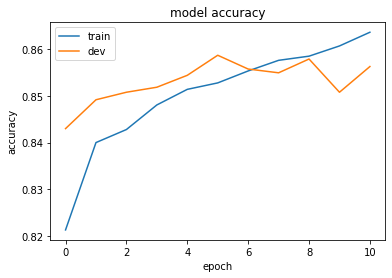

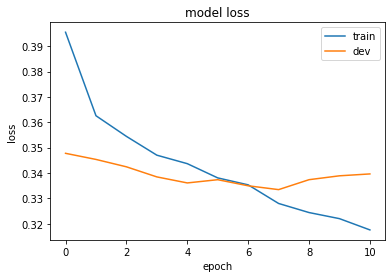

In [ ]:
plot_hist()

In [ ]:
with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(512, input_dim=x_dev_svd.shape[1] , activation='relu'))
  model.add(Dense(256,  activation='relu'))
  model.add(Dense(len(y_train.unique()),  activation='softmax'))
  #load weights from the pre-trained model
  model.load_weights("checkpoints/weights.hdf5")
  model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.01),
                    metrics=["accuracy"])

  print("\n----------------------Train Data----------------------")
  evaluation(model, x_train_svd, y_train)
  print("\n------------------Development Data-------------------")
  evaluation(model, x_dev_svd, y_dev)
  print("\n----------------------Test Data----------------------")
  evaluation(model, x_test_svd, y_test)


----------------------Train Data----------------------
1085/1085 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

    Negative     0.8768    0.8569    0.8667     17423
    Positive     0.8590    0.8786    0.8687     17282

    accuracy                         0.8677     34705
   macro avg     0.8679    0.8678    0.8677     34705
weighted avg     0.8679    0.8677    0.8677     34705

1085/1085 [==============================] - 2s 2ms/step
PR-AUC score Negative: 0.0566
1085/1085 [==============================] - 2s 1ms/step
PR-AUC score Positive: 0.9434 

1085/1085 [==============================] - 2s 2ms/step
Macro average PR-AUC score: 0.8151 


------------------Development Data-------------------
233/233 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

    Negative     0.8622    0.8478    0.8549      3652
    Positive     0.8555    0.8693    0.8623      3787

    accuracy    

#### **MLP classifier 3**

* **Layers:** four (two hidden layers) 
* **Activation function:** relu and softmax(final)
* **Regularizer:** bias regularizer
* **Loss function:** binary cross entropy
* **Optimizer:** Adam (0.01 learning rate)

Changes from the previous
1. Add one new layer
1. Remove Dropout
2. Add layer weight regularizers

In [ ]:
from tensorflow.keras import regularizers
with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(256, input_dim=x_train_svd.shape[1] , activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(128,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(128,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(len(y_train_1_hot[0]),  activation='softmax'))

  print(model.summary())
  model.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.01),
                    metrics=["accuracy"])

  if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

  checkpoint = ModelCheckpoint('checkpoints/weights.hdf5',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)

  history = model.fit(x_train_svd, y_train_1_hot,
                validation_data=(x_dev_svd, y_dev_1_hot),
                batch_size=256,
                epochs=100,
                shuffle=True,
                callbacks=[Metrics(valid_data=(x_dev_svd, y_dev_1_hot)),
                checkpoint, es])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               25856     
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 2)                 258       
                                                                 
Total params: 75,522
Trainable params: 75,522
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
233/233 [==============================] - 0s 1ms/step
 — val_f1: 0.843743 — val_precision: 0.845169 — val_recall: 0.843796

Epoch 1: val_f1 improved from -inf to 0.

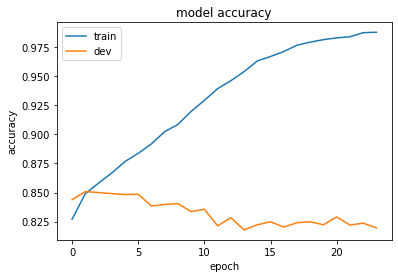

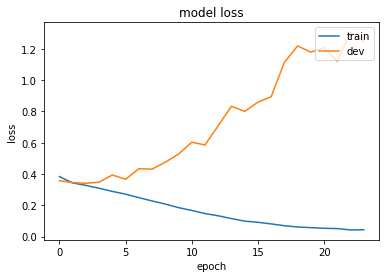

In [ ]:
plot_hist()

In [ ]:
with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(256, input_dim=x_dev_svd.shape[1] , activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(128,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(128,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(len(y_train.unique()),  activation='softmax'))
  #load weights from the pre-trained model
  model.load_weights("checkpoints/weights.hdf5")
  model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.01),
                    metrics=["accuracy"])

  print("\n----------------------Train Data----------------------")
  evaluation(model, x_train_svd, y_train)
  print("\n------------------Development Data-------------------")
  evaluation(model, x_dev_svd, y_dev)
  print("\n----------------------Test Data----------------------")
  evaluation(model, x_test_svd, y_test)


----------------------Train Data----------------------
1085/1085 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

    Negative     0.8732    0.8519    0.8624     17423
    Positive     0.8542    0.8752    0.8646     17282

    accuracy                         0.8635     34705
   macro avg     0.8637    0.8636    0.8635     34705
weighted avg     0.8637    0.8635    0.8635     34705

1085/1085 [==============================] - 2s 1ms/step
PR-AUC score Negative: 0.0611
1085/1085 [==============================] - 2s 1ms/step
PR-AUC score Positive: 0.9389 

1085/1085 [==============================] - 2s 1ms/step
Macro average PR-AUC score: 0.8098 


------------------Development Data-------------------
233/233 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

    Negative     0.8536    0.8401    0.8468      3652
    Positive     0.8481    0.8611    0.8546      3787

    accuracy    

#### **MLP classifier 4**

# New Section

* **Layers:** five (three hidden layers)
* **Activation function:** relu and softmax(final)
* **Regularizer:** bias regularizer
* **Loss function:** binary cross entropy
* **Optimizer:** Adam (0.01 learning rate)

Changes from previous
1. Add one new layer
2. Nodes in layers all the same (256)




In [ ]:
with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(256, input_dim=x_train_svd.shape[1] , activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dropout(0.7))
  model.add(Dense(256,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dropout(0.7))
  model.add(Dense(256,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dropout(0.7))
  model.add(Dense(256,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dropout(0.7))
  model.add(Dense(len(y_train_1_hot[0]),  activation='softmax'))

  print(model.summary())
  model.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.01),
                    metrics=["accuracy"])

  if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

  checkpoint = ModelCheckpoint('checkpoints/weights.hdf5',
                                                 monitor='val_f1', 
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)

  history = model.fit(x_train_svd, y_train_1_hot,
                validation_data=(x_dev_svd, y_dev_1_hot),
                batch_size=256,
                epochs=100,
                shuffle=True,
                callbacks=[Metrics(valid_data=(x_dev_svd, y_dev_1_hot)),
                checkpoint, es])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               25856     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 256)              

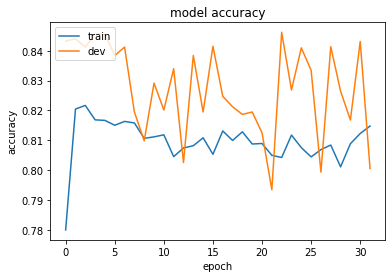

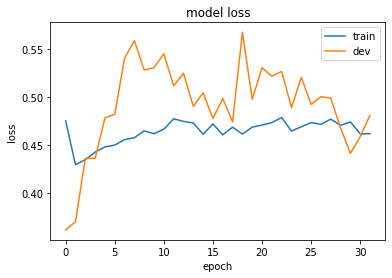

In [ ]:
plot_hist()

In [ ]:
with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(256, input_dim=x_dev_svd.shape[1] , activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(256,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(256,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(256,  activation='relu',bias_regularizer=regularizers.l2(0.002)))
  model.add(Dense(len(y_train.unique()),  activation='softmax'))
  #load weights from the pre-trained model
  model.load_weights("checkpoints/weights.hdf5")
  model.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.01),
                    metrics=["accuracy"])

  print("\n----------------------Train Data----------------------")
  evaluation(model, x_train_svd, y_train)
  print("\n------------------Development Data-------------------")
  evaluation(model, x_dev_svd, y_dev)
  print("\n----------------------Test Data----------------------")
  evaluation(model, x_test_svd, y_test)


----------------------Train Data----------------------
1085/1085 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

    Negative     0.8802    0.8107    0.8440     17423
    Positive     0.8232    0.8887    0.8547     17282

    accuracy                         0.8495     34705
   macro avg     0.8517    0.8497    0.8493     34705
weighted avg     0.8518    0.8495    0.8493     34705

1085/1085 [==============================] - 2s 2ms/step
PR-AUC score Negative: 0.0672
1085/1085 [==============================] - 2s 2ms/step
PR-AUC score Positive: 0.9328 

1085/1085 [==============================] - 2s 2ms/step
Macro average PR-AUC score: 0.7870 


------------------Development Data-------------------
233/233 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    Negative     0.8748    0.8015    0.8365      3652
    Positive     0.8229    0.8894    0.8548      3787

    accuracy    

## **References**

* https://scikit-learn.org/
* https://stackabuse.com/text-classification-with-python-and-scikit-learn/
* https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6
* https://stackoverflow.com/questions/24169238/dealing-with-negative-values-in-sklearn-multinomialnb
* https://medium.com/analytics-vidhya/the-best-feature-selection-technique-for-text-classification-23199b4a4f8d
